# Transfer Learning

In [0]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Deep_Learning_Udemy/a6_Transfer_Learning'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import os
from torch.autograd import  Variable

# Load Data

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.486, 0.406], [0.229, 0.224, 0.225])
                                 ]),
                  'val': transforms.Compose([
                                             transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.486, 0.406], [0.229, 0.224, 0.225])
                  ])}

In [0]:
data_dir = "/content/drive/My Drive/Deep_Learning_Udemy/a6_Transfer_Learning/hymenoptera_data"
# Create a dictionary that contains the informations of the images in both the training and the validation sets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'val']}
# Create a dictionart that contains the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4, shuffle=True) for x in ['train', 'val'] }
# Create a dictionary that contains size of each dataset (training and validation)
data_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Get the class names
class_names = image_datasets['train'].classes

# Print out the results
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the validation set".format(len(dataloaders['val'])))
print("There are {} training images".format(data_size['train']))
print("There are {} validation images".format(data_size['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the validation set
There are 244 training images
There are 153 validation images


In [0]:
# Load the ResNet
model_conv = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Freeze all the layers in the network
for param in model_conv.parameters():
  param.requires_grad = False

In [0]:
# Get the input of the last layer (or number of neurons in the layer proceeding the last layer)
num_ftrs = model_conv.fc.in_features
# Reconstruct the last layer (output layer) to have only two classes
model_conv.fc = nn.Linear(in_features=num_ftrs, out_features=2)

In [0]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = model_conv.to(device)

In [0]:
# Understand What is happening
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
  if iteration == 1:
    break
  inputs = Variable(inputs)
  labels = Variable(labels)
  inputs = inputs.to(device)
  labels = labels.to(device)
  print("For one iteration this is what happens: ")
  print("Input Shape: {}".format(inputs.shape))
  print("Labels Shape: {}".format(labels.shape))
  print("Labels are: {}".format(labels))

  output = model_conv(inputs)
  print("Output Tensor: {}".format(output))
  print("Output Shape: {}".format(output.shape))
  _, predicted = torch.max(output, 1)
  print("Prediction : {}".format(predicted))
  print("Prediction Shape: {}".format(predicted.shape))
  correct += (predicted == labels).sum()
  print("Correct Prediction: {}".format(correct))

  iteration += 1



For one iteration this is what happens: 
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 1, 1, 0], device='cuda:0')
Output Tensor: tensor([[ 0.0595, -0.4247],
        [ 0.4569, -0.4204],
        [-0.3231, -0.6587],
        [-0.6905, -0.7709]], device='cuda:0', grad_fn=<AddmmBackward>)
Output Shape: torch.Size([4, 2])
Prediction : tensor([0, 0, 0, 0], device='cuda:0')
Prediction Shape: torch.Size([4])
Correct Prediction: 1


In [0]:
# Loss Function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)
#Try experimenting with : optim.Adam(model_conv.fc.parameters(), lr =0.001)
# Decay learning rate by a factor 0.1 every 7 epochs
exp_lr_schedular = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1 )

In [0]:
a = 0.001 * (0.1 ** (8//7))
a

0.0001

In [0]:
# Training the network
num_epochs = 25
for epoch in range (num_epochs):
  correct=0
  exp_lr_schedular.step()
  for images, labels in dataloaders['train']:
    images = Variable(images)
    labels = Variable(labels)
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model_conv(images)
    
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
  
  train_acc = 100 * correct / data_size['train']
  print("Epoch [{}/{}] Loss: {:.4f} Training Accuracy: {}%".format(epoch, num_epochs, loss.item(),train_acc)) 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch [0/25] Loss: 0.2295 Training Accuracy: 64%
Epoch [1/25] Loss: 0.3684 Training Accuracy: 79%
Epoch [2/25] Loss: 0.4553 Training Accuracy: 76%
Epoch [3/25] Loss: 0.1704 Training Accuracy: 78%
Epoch [4/25] Loss: 0.0626 Training Accuracy: 81%
Epoch [5/25] Loss: 0.0116 Training Accuracy: 84%
Epoch [6/25] Loss: 0.0095 Training Accuracy: 87%
Epoch [7/25] Loss: 0.1259 Training Accuracy: 87%
Epoch [8/25] Loss: 0.2670 Training Accuracy: 85%
Epoch [9/25] Loss: 0.0175 Training Accuracy: 82%
Epoch [10/25] Loss: 0.8091 Training Accuracy: 85%
Epoch [11/25] Loss: 0.0972 Training Accuracy: 84%
Epoch [12/25] Loss: 0.1617 Training Accuracy: 81%
Epoch [13/25] Loss: 0.0086 Training Accuracy: 81%
Epoch [14/25] Loss: 0.0216 Training Accuracy: 79%
Epoch [15/25] Loss: 0.3476 Training Accuracy: 87%
Epoch [16/25] Loss: 0.2151 Training Accuracy: 82%
Epoch [17/25] Loss: 0.5830 Training Accuracy: 84%
Epoch [18/25] Loss: 0.0881 Training Accuracy: 83%
Epoch [19/25] Loss: 0.1326 Training Accuracy: 86%
Epoch [20/

In [0]:
# Test Model
model_conv.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in dataloaders['val']:
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)
    outputs = model_conv(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
     
  print("Test Accuracy: {}".format(100* (correct/total)))



Test Accuracy: 94.77124183006535


In [0]:
import matplotlib.pyplot as plt

torch.Size([4])


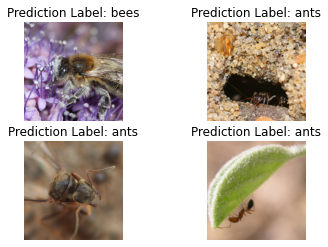

In [0]:
# Visualize some predictions
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in dataloaders['val']:
    if shown_batch == 1:
      break
    shown_batch +=1
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)
    outputs = model_conv(images)                    # the output is of shape (4,2)
    _, predicted = torch.max(outputs.data, 1)       # the prediction is of shape (4) ------------> [0, 0, 0, 1]
    print(predicted.shape)
    for i in range(4):
      index+=1
      ax = plt.subplot(2, 2, index)
      ax.axis('off')
      ax.set_title("Prediction Label: {}".format(class_names[predicted[i]]))
      input_img = images.cpu().data[i]                              # Get the tesnsor of the image and put it to cpu
      inp = input_img.numpy().transpose((1, 2, 0))                  # If we have tensor of shape (2, 3, 4) ----> it becomes(3, 4, 2)
      mean = np.array([0.485, 0.486, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)

     